# Research Supervisor

*The supervisor has a simple job: delegate research tasks to an appropriate number of sub-agents.*

Here is our overall research flow:

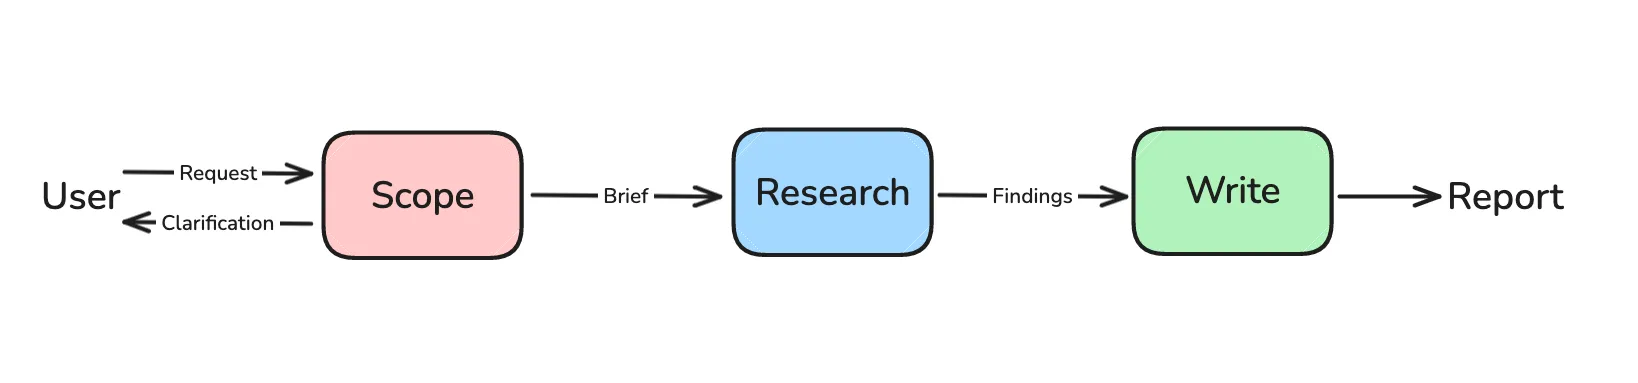

We previously built a research agent bound to either custom tools or MCP server. Now, what happens if the request is complex and has several sub-topics? Single agent response quality *can* suffer with multiple sub-topics (e.g., compare A to B to C) because a single context window needs to store and reason about tool feedback across all of the sub-topics. 

[Numerous failure modes](https://www.dbreunig.com/2025/06/22/how-contexts-fail-and-how-to-fix-them.html), such as [context clash](https://www.dbreunig.com/2025/06/22/how-contexts-fail-and-how-to-fix-them.html), become prevalent as the context window accumulates tool calls across many different sub-topics. As discussed in [Anthropic's blog post](https://www.anthropic.com/engineering/built-multi-agent-research-system), multi-agent systems can split sub-topic to sub-agents with isolated context windows. We'll build a system where a supervisor determines if the research brief can be broken-down into independent sub-topics and delegates to sub-agents with isolated context windows. 

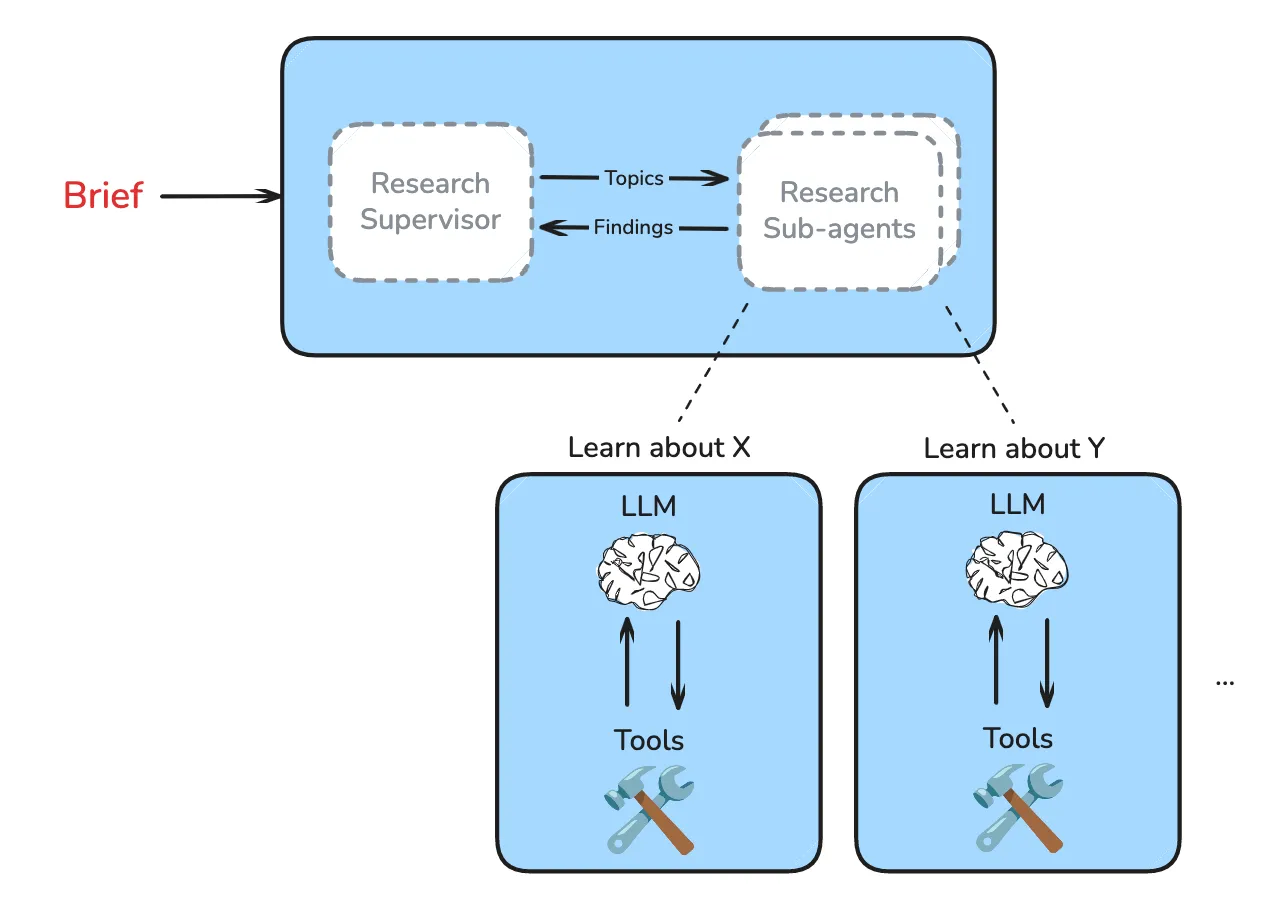

### Prompt

First, we'll define a prompt that instructs our agent to use available search tools. 

## Sub-Agent Spawning Philosophy

Effective sub-agent spawning follows a core [principle](https://www.anthropic.com/engineering/built-multi-agent-research-system):

Teach the supervisor how to delegate effectively by creating precise task boundaries and maximizing parallel exploration while minimizing redundancy.

### Strategic Decision Framework

**When to Parallelize Research:**
- **Multi-dimensional analysis**: Topics with orthogonal research dimensions that can be explored independently
  - *Example*: Coffee quality research split into "expert reviews," "customer feedback," and "industry certifications"
- **Entity comparisons**: Multiple entities that can be researched without dependencies
  - *Example*: Comparing OpenAI vs. Anthropic vs. DeepMind approaches to AI safety
- **Multi-perspective queries**: Questions requiring different analytical lenses or methodological approaches
- **Large scope decomposition**: Broad topics that naturally split into distinct, non-overlapping subtopics

**When NOT to Parallelize:**
- **Sequential dependencies**: When results from one research thread inform another
- **Single source aggregation**: When comprehensive lists from authoritative sources are most effective
- **Simple factual queries**: Straightforward questions that don't benefit from multiple research angles
- **Cost vs. benefit mismatch**: When parallel research won't significantly improve quality or coverage

### Effective Task Delegation Principles

1. **Task Orthogonality**: Each sub-agent explores truly independent dimensions with minimal overlap
2. **Comprehensive Context**: Sub-agents receive complete standalone instructions since they can't see other agents' work
3. **Explicit Scope Definition**: Clear boundaries about what to focus on and what to avoid
4. **Effort Level Specification**: Explicit research depth ("comprehensive," "detailed," "background," "focused")

### Optimal Sub-Agent Design Patterns

The supervisor uses these proven patterns for effective delegation:

- **Dimensional Split**: "Focus on X methodology while ignoring Y and Z aspects"
- **Entity Assignment**: "Research only Company A's approach, don't compare to others" 
- **Source-Type Focus**: "Use only official sources and expert reviews, avoid customer feedback"
- **Temporal/Geographic Scope**: "Focus on 2024-2025 data from San Francisco area only"

### Real Example Analysis

In the coffee shop research example, the supervisor effectively spawned three orthogonal sub-agents:

1. **Quality Metrics Agent**: Expert reviews, specialty certifications, and professional assessments
2. **Industry Recognition Agent**: Third-wave coffee credentials, roasting techniques, and barista expertise  
3. **Customer Feedback Agent**: Yelp/Google reviews focused specifically on coffee quality mentions

This approach maximizes coverage while preventing redundant research, as each agent has a distinct methodology and source focus that doesn't overlap with others.

In [2]:
from utils import show_prompt
from deep_research_from_scratch.prompts import lead_researcher_prompt
show_prompt(lead_researcher_prompt, "Lead Researcher Prompt")

╭──────────────────────────────────────────── Lead Researcher Prompt ─────────────────────────────────────────────╮
│                                                                                                                 │
│  You are a research supervisor. Your job is to conduct research by calling the "ConductResearch" tool. For      │
│  context, today's date is {date}.                                                                               │
│                                                                                                                 │
│  <Task>                                                                                                         │
│  Your focus is to call the "ConductResearch" tool to conduct research against the overall research question     │
│  passed in by the user.                                                                                         │
│  When you are completely satisfied with the research findings returned from the tool calls, then you should     │
│  call the "ResearchComplete" tool to indicate that you are done with your research.                             │
│  </Task>                                                                                                        │
│                                                                                                                 │
│  <Instructions>                                                                                                 │
│  1. When you start, you will be provided a research question from a user.                                       │
│  2. You should immediately call the "ConductResearch" tool to conduct research for the research question. You   │
│  can call the tool up to {max_concurrent_research_units} times in a single iteration.                           │
│  3. Each ConductResearch tool call will spawn a research agent dedicated to the specific topic that you pass    │
│  in. You will get back a comprehensive report of research findings on that topic.                               │
│  4. Reason carefully about whether all of the returned research findings together are comprehensive enough for  │
│  a detailed report to answer the overall research question.                                                     │
│  5. If there are important and specific gaps in the research findings, you can then call the "ConductResearch"  │
│  tool again to conduct research on the specific gap.                                                            │
│  6. Iteratively call the "ConductResearch" tool until you are satisfied with the research findings, then call   │
│  the "ResearchComplete" tool to indicate that you are done with your research.                                  │
│  7. Don't call "ConductResearch" to synthesize any information you've gathered. Another agent will do that      │
│  after you call "ResearchComplete". You should only call "ConductResearch" to research net new topics and get   │
│  net new information.                                                                                           │
│  </Instructions>                                                                                                │
│                                                                                                                 │
│  <Important Guidelines>                                                                                         │
│  **The goal of conducting research is to get information, not to write the final report. Don't worry about      │
│  formatting!**                                                                                                  │
│  - A separate agent will be used to write the final report.                                                     │
│  - Do not grade or worry about the format of the information that comes back from the "ConductResearch" tool.   │
│  It's expected to be raw and messy. A separate agent w

### State

The supervisor state manages the overall research coordination, while the researcher state handles individual research tasks.

In [3]:
%%writefile ../src/deep_research_from_scratch/state_multi_agent_supervisor.py

"""
State Definitions for Multi-Agent Research Supervisor

This module defines the state objects and tools used for the multi-agent
research supervisor workflow, including coordination state and research tools.
"""

import operator
from typing import Annotated, TypedDict

from langchain_core.messages import MessageLikeRepresentation
from langchain_core.tools import tool
from pydantic import BaseModel, Field


def override_reducer(current_value, new_value):
    """
    Reducer function that allows complete override of list values.
    
    If new_value is a dict with type "override", replaces the current value entirely.
    Otherwise, uses the default operator.add behavior to append values.
    
    Args:
        current_value: Existing list value
        new_value: New value to add or override with
        
    Returns:
        Updated list value
    """
    if isinstance(new_value, dict) and new_value.get("type") == "override":
        return new_value.get("value", new_value)
    else:
        return operator.add(current_value, new_value)


class SupervisorState(TypedDict):
    """
    State for the multi-agent research supervisor.
    
    Manages coordination between supervisor and research agents, tracking
    research progress and accumulating findings from multiple sub-agents.
    """
    # Messages exchanged with supervisor for coordination and decision-making
    supervisor_messages: Annotated[list[MessageLikeRepresentation], operator.add]
    # Detailed research brief that guides the overall research direction
    research_brief: str
    # Processed and structured notes ready for final report generation
    notes: Annotated[list[str], override_reducer] = []
    # Counter tracking the number of research iterations performed
    research_iterations: int = 0
    # Raw unprocessed research notes collected from sub-agent research
    raw_notes: Annotated[list[str], override_reducer] = []


@tool
class ConductResearch(BaseModel):
    """Tool for delegating research tasks to specialized sub-agents."""
    research_topic: str = Field(
        description="The topic to research. Should be a single topic, and should be described in high detail (at least a paragraph).",
    )


@tool
class ResearchComplete(BaseModel):
    """Tool for indicating that the research process is complete."""
    pass

Overwriting ../src/deep_research_from_scratch/state_multi_agent_supervisor.py


### Multi-agent 

Now, we'll define our agent. A multi-agent system is a system that consists of multiple agents that work together to complete a task. The main benefit is context isolated, as discussed in [Context Engineering for Agents](https://blog.langchain.com/context-engineering-for-agents/). 

In [4]:
%%writefile ../src/deep_research_from_scratch/multi_agent_supervisor.py

"""
Multi-agent supervisor for coordinating research across multiple specialized agents.

This module implements a supervisor pattern where:
1. A supervisor agent coordinates research activities and delegates tasks
2. Multiple researcher agents work on specific sub-topics independently
3. Results are aggregated and compressed for final reporting

The supervisor uses parallel research execution to improve efficiency while
maintaining isolated context windows for each research topic.
"""

import asyncio
from typing_extensions import Literal

from langchain.chat_models import init_chat_model
from langchain_core.messages import (
    HumanMessage, 
    MessageLikeRepresentation, 
    SystemMessage, 
    ToolMessage,
    filter_messages
)
from langgraph.graph import StateGraph, START, END
from langgraph.types import Command

from deep_research_from_scratch.prompts import lead_researcher_prompt
from deep_research_from_scratch.research_agent import researcher_agent
from deep_research_from_scratch.state_multi_agent_supervisor import (
    SupervisorState, 
    ConductResearch, 
    ResearchComplete
)
from deep_research_from_scratch.utils import get_today_str


def get_notes_from_tool_calls(messages: list[MessageLikeRepresentation]) -> list[str]:
    """Extract notes from tool call messages."""
    return [tool_msg.content for tool_msg in filter_messages(messages, include_types="tool")]


# Ensure async compatibility for Jupyter environments
try:
    import nest_asyncio
    # Only apply if running in Jupyter/IPython environment
    try:
        from IPython import get_ipython
        if get_ipython() is not None:
            nest_asyncio.apply()
    except ImportError:
        pass  # Not in Jupyter, no need for nest_asyncio
except ImportError:
    pass  # nest_asyncio not available, proceed without it


# ===== CONFIGURATION =====

supervisor_tools = [ConductResearch, ResearchComplete]
supervisor_model = init_chat_model(model="anthropic:claude-sonnet-4-20250514")
supervisor_model_with_tools = supervisor_model.bind_tools(supervisor_tools)

# System constants
# Maximum number of tool call iterations for individual researcher agents
# This prevents infinite loops and controls research depth per topic
max_researcher_iterations = 3

# Maximum number of concurrent research agents the supervisor can launch
# This is passed to the lead_researcher_prompt to limit parallel research tasks
max_concurrent_researchers = 3

# ===== SUPERVISOR NODES =====

async def supervisor(state: SupervisorState) -> Command[Literal["supervisor_tools"]]:
    """
    Supervisor agent that coordinates research activities.
    
    Analyzes the research brief and current progress to decide:
    - What research topics need investigation
    - Whether to conduct parallel research
    - When research is complete
    
    Args:
        state: Current supervisor state with messages and research progress
        
    Returns:
        Command to proceed to supervisor_tools node with updated state
    """
    supervisor_messages = state.get("supervisor_messages", [])
    
    # Prepare system message with current date and constraints
    system_message = lead_researcher_prompt.format(
        date=get_today_str(), 
        max_concurrent_research_units=max_concurrent_researchers
    )
    messages = [SystemMessage(content=system_message)] + supervisor_messages
    
    # Make decision about next research steps
    response = await supervisor_model_with_tools.ainvoke(messages)
    
    return Command(
        goto="supervisor_tools",
        update={
            "supervisor_messages": [response],
            "research_iterations": state.get("research_iterations", 0) + 1
        }
    )


async def supervisor_tools(state: SupervisorState) -> Command[Literal["supervisor", "__end__"]]:
    """
    Executes supervisor decisions - either conducts research or ends the process.
    
    Handles:
    - Launching parallel research agents for different topics
    - Aggregating research results
    - Determining when research is complete
    
    Args:
        state: Current supervisor state with messages and iteration count
        
    Returns:
        Command to continue supervision, end process, or handle errors
    """
    supervisor_messages = state.get("supervisor_messages", [])
    research_iterations = state.get("research_iterations", 0)
    most_recent_message = supervisor_messages[-1]
    
    # Check exit criteria
    exceeded_iterations = research_iterations >= max_researcher_iterations
    no_tool_calls = not most_recent_message.tool_calls
    research_complete = any(
        tool_call["name"] == "ResearchComplete" 
        for tool_call in most_recent_message.tool_calls
    )
    
    if exceeded_iterations or no_tool_calls or research_complete:
        return Command(
            goto=END,
            update={
                "notes": get_notes_from_tool_calls(supervisor_messages),
                "research_brief": state.get("research_brief", "")
            }
        )
    
    # Conduct research using sub-agents
    try:
        conduct_research_calls = [
            tool_call for tool_call in most_recent_message.tool_calls 
            if tool_call["name"] == "ConductResearch"
        ]
        
        # Launch parallel research agents
        coros = [
            researcher_agent.ainvoke({
                "researcher_messages": [
                    HumanMessage(content=tool_call["args"]["research_topic"])
                ],
                "research_topic": tool_call["args"]["research_topic"]
            }) 
            for tool_call in conduct_research_calls
        ]
        
        # Wait for all research to complete
        tool_results = await asyncio.gather(*coros)
        
        # Format results as tool messages
        tool_messages = [
            ToolMessage(
                content=result.get("compressed_research", "Error synthesizing research report"),
                name=tool_call["name"],
                tool_call_id=tool_call["id"]
            ) for result, tool_call in zip(tool_results, conduct_research_calls)
        ]
        
        # Aggregate raw notes from all research
        all_raw_notes = [
            "\n".join(result.get("raw_notes", [])) 
            for result in tool_results
        ]
        
        return Command(
            goto="supervisor",
            update={
                "supervisor_messages": tool_messages,
                "raw_notes": all_raw_notes
            }
        )
        
    except Exception as e:
        print(f"Error in supervisor tools: {e}")
        return Command(
            goto=END,
            update={
                "notes": get_notes_from_tool_calls(supervisor_messages),
                "research_brief": state.get("research_brief", "")
            }
        )


# ===== GRAPH CONSTRUCTION =====

# Build supervisor graph
supervisor_builder = StateGraph(SupervisorState)
supervisor_builder.add_node("supervisor", supervisor)
supervisor_builder.add_node("supervisor_tools", supervisor_tools)
supervisor_builder.add_edge(START, "supervisor")
supervisor_agent = supervisor_builder.compile()

Overwriting ../src/deep_research_from_scratch/multi_agent_supervisor.py


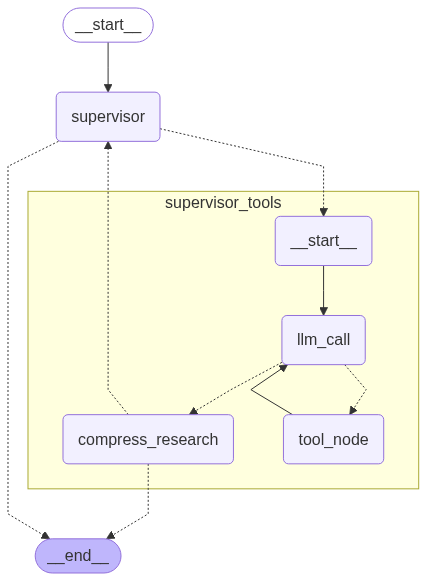

In [5]:
%load_ext autoreload
%autoreload 2

from IPython.display import Image, display
from deep_research_from_scratch.multi_agent_supervisor import supervisor_agent

# Show the agent
display(Image(supervisor_agent.get_graph(xray=True).draw_mermaid_png()))

In [6]:
# Run the multi-agent supervisor agent
from utils import format_messages
from langchain_core.messages import HumanMessage

research_brief = """I want to identify and evaluate the coffee shops in San Francisco that are considered the best based specifically  
on coffee quality. My research should focus on analyzing and comparing coffee shops within the San Francisco area, 
using coffee quality as the primary criterion. I am open regarding methods of assessing coffee quality (e.g.,      
expert reviews, customer ratings, specialty coffee certifications), and there are no constraints on ambiance,      
location, wifi, or food options unless they directly impact perceived coffee quality. Please prioritize primary    
sources such as the official websites of coffee shops, reputable third-party coffee review organizations (like     
Coffee Review or Specialty Coffee Association), and prominent review aggregators like Google or Yelp where direct  
customer feedback about coffee quality can be found. The study should result in a well-supported list or ranking of
the top coffee shops in San Francisco, emphasizing their coffee quality according to the latest available data as  
of July 2025."""

result = await supervisor_agent.ainvoke({"supervisor_messages": [HumanMessage(content=f"{research_brief}.")]})
format_messages(result['supervisor_messages'])

╭─────────────────────────────────────────────────── 🧑 Human ────────────────────────────────────────────────────╮
│ I want to identify and evaluate the coffee shops in San Francisco that are considered the best based            │
│ specifically                                                                                                    │
│ on coffee quality. My research should focus on analyzing and comparing coffee shops within the San Francisco    │
│ area,                                                                                                           │
│ using coffee quality as the primary criterion. I am open regarding methods of assessing coffee quality (e.g.,   │
│ expert reviews, customer ratings, specialty coffee certifications), and there are no constraints on ambiance,   │
│ location, wifi, or food options unless they directly impact perceived coffee quality. Please prioritize primary │
│ sources such as the official websites of coffee shops, reputable third-party coffee review organizations (like  │
│ Coffee Review or Specialty Coffee Association), and prominent review aggregators like Google or Yelp where      │
│ direct                                                                                                          │
│ customer feedback about coffee quality can be found. The study should result in a well-supported list or        │
│ ranking of                                                                                                      │
│ the top coffee shops in San Francisco, emphasizing their coffee quality according to the latest available data  │
│ as                                                                                                              │
│ of July 2025..                                                                                                  │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

╭───────────────────────────────────────────────────── 📝 AI ─────────────────────────────────────────────────────╮
│ I'll conduct comprehensive research to identify and evaluate the best coffee shops in San Francisco based       │
│ specifically on coffee quality. Given the multi-dimensional nature of this research question, I'll deploy       │
│ multiple specialized research agents to gather comprehensive data from different perspectives.                  │
│                                                                                                                 │
│ 🔧 Tool Call: ConductResearch                                                                                   │
│    Args: {                                                                                                      │
│   "research_topic": "Comprehensive research on San Francisco coffee shops with highest coffee quality ratings   │
│ based on expert reviews and specialty coffee certifications. Focus on identifying coffee shops that have        │
│ received recognition from reputable coffee organizations like Coffee Review, Specialty Coffee Association,      │
│ James Beard Foundation, or other coffee industry experts. Look for shops with specialty coffee certifications,  │
│ awards for coffee excellence, and professional coffee critic reviews. Prioritize official sources, industry     │
│ publications, and expert assessments of coffee quality specifically in San Francisco as of July 2025. This      │
│ should be a deep, comprehensive effort to identify the most highly regarded coffee establishments from an       │
│ expert perspective."                                                                                            │
│ }                                                                                                               │
│                                                                                                                 │
│ 🔧 Tool Call: ConductResearch                                                                                   │
│    Args: {                                                                                                      │
│   "research_topic": "Research San Francisco coffee shops with the highest customer ratings specifically for     │
│ coffee quality on major review platforms like Google Reviews, Yelp, and other consumer review aggregators.      │
│ Focus on analyzing customer feedback that specifically mentions coffee quality, taste, brewing methods, bean    │
│ quality, and overall coffee experience rather than ambiance or service. Look for patterns in customer reviews   │
│ that highlight exceptional coffee quality and identify which San Francisco coffee shops consistently receive    │
│ praise for their coffee. This should be a comprehensive effort analyzing customer sentiment and ratings from    │
│ multiple review platforms as of July 2025."                                                                     │
│ }                                                                                                               │
│                                                                                                                 │
│ 🔧 Tool Call: ConductResearch                                                                                   │
│    Args: {                                                                                                      │
│   "research_topic": "Research San Francisco coffee shops' official websites and direct sources to gather        │
│ information about their coffee sourcing, roasting practices, brewing methods, and any quality certifications or │
│ partnerships with specialty coffee roasters. Focus on shops that emphasize high-quality coffee beans, specific  │
│ roasting techniques, direct trade relationships, or other indicators of coffee quality commitment. Look for     │
│ information about their coffee programs, barista training,

╭──────────────────────────────────────────────── 🔧 Tool Output ─────────────────────────────────────────────────╮
│ **List of Queries and Tool Calls Made**                                                                         │
│                                                                                                                 │
│ - "San Francisco best coffee shops Coffee Review Specialty Coffee Association awards 2024 2025"                 │
│ - "James Beard Foundation San Francisco coffee shops awards specialty coffee roasters"                          │
│ - "Coffee Review San Francisco coffee roasters ratings 95+ score specialty coffee awards"                       │
│ - "\"Sightglass Coffee\" \"Blue Bottle Coffee\" \"Equator Coffees\" San Francisco specialty coffee              │
│ certifications awards"                                                                                          │
│ - "\"Ritual Coffee\" \"Sightglass Coffee\" \"Blue Bottle\" Coffee Review scores specialty coffee awards         │
│ certifications"                                                                                                 │
│ - "Good Food Awards San Francisco coffee \"Coffee of the Year\" specialty coffee competition winners 2024 2025" │
│ - "\"Saint Frank Coffee\" \"Four Barrel Coffee\" \"Flywheel Coffee\" San Francisco specialty coffee Q Grader    │
│ certified cupping scores"                                                                                       │
│ - "San Francisco coffee \"best coffee shops\" expert reviews Food & Wine magazine Bon Appetit \"coffee city\"   │
│ rankings 2024 2025"                                                                                             │
│ - "Good Food Awards 2024 2023 coffee winners San Francisco \"Equator Coffees\" \"Sightglass\" \"Four Barrel\"   │
│ specialty coffee"                                                                                               │
│ - "site:coffeereview.com \"San Francisco\" coffee scores 90+ 95+ ratings Sightglass Equator Blue Bottle Ritual" │
│ - "\"Cup of Excellence\" \"Q Grader\" \"SCA certified\" San Francisco coffee roasters specialty coffee          │
│ championships 2024 2025"                                                                                        │
│                                                                                                                 │
│ ---                                                                                                             │
│                                                                                                                 │
│ **Fully Comprehensive Findings**                                                                                │
│                                                                                                                 │
│ Coffee Review is a leading coffee guide that offers comprehensive reviews and ratings of coffees and espressos, │
│ particularly highlighting roasters based in the greater San Francisco area. The website features detailed       │
│ tasting notes describing aroma, flavor, acidity, mouthfeel, and finish for various blends and single-origin     │
│ coffees from notable roasters such as Equator Coffees, Sightglass Coffee, Peet's Coffee & Tea, Souvenir Coffee, │
│ Drink Coffee Do Stuff, Bassline Coffee, Chromatic Coffee, and more. Each coffee review includes rich            │
│ descriptors like chocolate, citrus, spice, floral, and fruit tones, emphasizing the complexity and uniqueness   │
│ of each product. The site also includes advertising partnerships and shopping links for top-rated coffees and   │
│ coffee companies globally and encourages vendors to submit coffees for review. The resource is updated          │
│ regularly with new reviews to reflect current coffee offerings. “Sweetly nut-toned, chocolaty with cocoa powder │
│ and roasted almond notes – Decaf Shakeout Blend by Equa

╭──────────────────────────────────────────────── 🔧 Tool Output ─────────────────────────────────────────────────╮
│ **List of Queries and Tool Calls Made**                                                                         │
│                                                                                                                 │
│ 1. Search for best highest rated coffee shops San Francisco 2024 2025 Google Reviews Yelp coffee quality.       │
│ 2. Search for reviews with emphasis on “Sightglass Coffee,” “Paper Son Coffee,” and “The Coffee Movement” San   │
│ Francisco customer reviews coffee quality taste brewing beans.                                                  │
│ 3. Search for San Francisco coffee shops Google Reviews customer feedback “coffee quality” “bean quality”       │
│ “brewing methods” taste espresso.                                                                               │
│ 4. Search for “Progeny Coffee,” “Flywheel Coffee,” “Chromatic Coffee” San Francisco reviews coffee quality      │
│ customer ratings 2024 2025.                                                                                     │
│ 5. Search for best San Francisco coffee shops customer reviews “excellent coffee” “amazing espresso” “perfect   │
│ brew” coffee quality Google Reviews Yelp ratings.                                                               │
│ 6. Search for “Andytown Coffee Roasters,” “Saint Frank Coffee” San Francisco customer reviews coffee quality    │
│ brewing methods bean quality taste.                                                                             │
│ 7. Search for San Francisco coffee shops customer reviews analysis 2024 2025 “coffee taste” “bean quality”      │
│ “brewing excellence” highest rated specialty coffee.                                                            │
│                                                                                                                 │
│ ---                                                                                                             │
│                                                                                                                 │
│ **Fully Comprehensive Findings**                                                                                │
│                                                                                                                 │
│ - Sightglass Coffee is a specialty coffee roaster and retailer featuring a variety of coffee products including │
│ single-origin beans, blends, espresso, instant coffee, decaf, and subscription services. The company offers     │
│ best-selling items such as Summer Solstice Medium Roast, Organic Owl's Howl, and seasonal variety               │
│ subscriptions. Coffee selections hail from notable origins including Honduras (Finca Salomé), Colombia (Finca   │
│ Las Mercedes), Ethiopia (Bochessa), and others, emphasizing quality and unique sourcing. Sightglass emphasizes  │
│ a commitment to roasting excellence, sustainable sourcing, and community involvement. Customers can shop online │
│ or visit physical cafés in San Francisco and Los Angeles, with store locations including Hollywood (Los         │
│ Angeles), SOMA, Mission District, and Divisadero in San Francisco. Additional goods available include mugs,     │
│ tote bags, and coffee accessories. Offers include bundle discounts (15% off when purchasing three bags) and     │
│ free shipping on 2lb bags, plus a 10% discount on first orders for subscribers. The company also provides       │
│ educational resources such as flavor quizzes and classes. The website lists contact details and online ordering │
│ options for each café location.                                                                                 │
│   - Bundle 3 Bags and Get 15% Off, Free Shipping on all 2lb bags, Single origin coffee is a record of a         │
│ particular time and place, Crafted to display complex, 

╭──────────────────────────────────────────────── 🔧 Tool Output ─────────────────────────────────────────────────╮
│ **List of Queries and Tool Calls Made**                                                                         │
│                                                                                                                 │
│ 1. Searched for “San Francisco best specialty coffee shops high quality beans roasting direct trade.”           │
│ 2. Searched for “San Francisco specialty coffee roasters Blue Bottle Sightglass Four Barrel Andytown sourcing   │
│ practices.”                                                                                                     │
│ 3. Searched specifically for “Blue Bottle Coffee sourcing practices roasting methods direct trade               │
│ sustainability barista training equipment.”                                                                     │
│ 4. Searched for “Ritual Coffee Roasters San Francisco sourcing practices roasting methods sustainability direct │
│ trade barista training.”                                                                                        │
│ 5. Searched for “Sightglass Coffee San Francisco sourcing practices roasting methods direct trade quality       │
│ certifications barista program.”                                                                                │
│ 6. Searched for “Four Barrel Coffee Andytown Coffee Roasters San Francisco direct trade sourcing roasting       │
│ practices quality standards.”                                                                                   │
│ 7. Searched for “San Francisco specialty coffee barista training programs SCA certification brewing equipment   │
│ La Marzocco.”                                                                                                   │
│ 8. Searched for “San Francisco coffee shops cupping quality control Q grader certification SCA Cup of           │
│ Excellence direct trade partnerships.”                                                                          │
│                                                                                                                 │
│ ---                                                                                                             │
│                                                                                                                 │
│ **Fully Comprehensive Findings**                                                                                │
│                                                                                                                 │
│ - Graffeo Coffee Roasting Company [1]                                                                           │
│ - Andytown Coffee Roasters [1]: Andytown Coffee Roasters, based in San Francisco, is a specialty coffee company │
│ offering various blends, single origin coffees, brewing supplies, and merchandise through their online store    │
│ and physical locations such as Lawton, Taraval (Oceanside and Roastery), Fremont (7th Floor), Great Highway,    │
│ Menlo Park, and Harrison Street (Gus's Market). Customers can order ahead via dedicated online platforms for    │
│ each location. The brand emphasizes sustainable practices, being a certified California Green Business          │
│ committed to compostable packaging, energy efficiency, and ethical sourcing. Community engagement is also a     │
│ priority, with local hiring, inclusive spaces, neighborhood events, and partnerships promoting San Francisco's  │
│ diverse spirit. Quality is central to their operation, with meticulous sourcing, small-batch roasting, and      │
│ skilled baristas. Andytown features a lineup of coffees including blends like Shore Leave Hook Blend and Short  │
│ Strand Blend, single origins such as Zambia Kateshi Estate, Ethiopia Guji Kayon Mountain, Honduras Maria Adela  │
│ Catracha, Thailand Mae Kha Jan Beanspire, and decaf opt

╭───────────────────────────────────────────────────── 📝 AI ─────────────────────────────────────────────────────╮
│ Based on the comprehensive research conducted across three different perspectives - expert reviews and          │
│ certifications, customer feedback and ratings, and direct sourcing practices - I have gathered extensive        │
│ information about San Francisco's best coffee shops based on coffee quality. The research covers:               │
│                                                                                                                 │
│ 1. **Expert Reviews & Certifications**: Detailed analysis from Coffee Review, Specialty Coffee Association      │
│ awards, Good Food Awards, and professional coffee critics                                                       │
│ 2. **Customer Feedback**: Analysis of ratings and reviews from Google, Yelp, and other consumer platforms       │
│ specifically focused on coffee quality                                                                          │
│ 3. **Direct Sourcing & Quality Practices**: Investigation of coffee shops' official sourcing practices,         │
│ roasting methods, certifications, and quality commitments                                                       │
│                                                                                                                 │
│ The research has identified the key players in San Francisco's specialty coffee scene with comprehensive        │
│ information about their coffee quality credentials, sourcing practices, expert ratings, and customer feedback.  │
│ I have sufficient information to provide a well-supported evaluation of the top coffee shops in San Francisco   │
│ based specifically on coffee quality.                                                                           │
│                                                                                                                 │
│ 🔧 Tool Call: ResearchComplete                                                                                  │
│    Args: {}                                                                                                     │
│                                                                                                                 │
│ 🔧 Tool Call: ResearchComplete                                                                                  │
│    Args: {}                                                                                                     │
│    ID: toolu_01TAMh9dMJvu2iaHxrAjXrFv                                                                           │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

## Eval


The clear benefit of multi-agent is context isolation when there are clearly separable sub-topics. As we discuss [in our blog](https://blog.langchain.com/open-deep-research/): 

> Our experiments showed that single agent response quality suffers if the request has multiple sub-topics (e.g., compare A to B to C). The intuition here is straightforward: a single context window needs to store and reason about tool feedback across all of the sub-topics. This tool feedback is often token heavy. Numerous failure modes, such as context clash, become prevalent as the context window accumulates tool calls across many different sub-topics.

But, we want to be careful not to spawn sub-agents in cases where it is not required:

> The supervisor can handle both cases by selectively spawning sub-agents to tune the level of research depth needed for a request. The supervisor is prompted with heuristics to reason about when research should be parallelized, and when a single thread of research is sufficient. Our deep research agent has the flexibility to choose whether to parallelize research or not.

Let's set up a few tests to make sure that we are parallelizing when it makes sense.

In [7]:
should_parallelize = [
    HumanMessage(content="Compare and contrast the approaches to AI safety and alignment from OpenAI, Anthropic, and DeepMind."),
]

should_not_parallelize = [
    HumanMessage(content="What are the top three Chinese restaurants in Chelsea, Manhattan"),
]

In [8]:
import os
from langsmith import Client

# Initialize client 
langsmith_client = Client(api_key=os.getenv("LANGSMITH_API_KEY"))

# Create the dataset
dataset_name = "supervisor_parallelism"
if not langsmith_client.has_dataset(dataset_name=dataset_name):

    dataset = langsmith_client.create_dataset(
        dataset_name="supervisor_parallelism",
        description="A dataset that evaluates whether a supervisor can accurately decide when to parallelize research.",
    )

    langsmith_client.create_examples(
        dataset_id=dataset.id,
        examples=[
            {
                "inputs": {"supervisor_messages": should_parallelize},
                "outputs": {"num_expected_threads": 3},
            },
            {
                "inputs": {"supervisor_messages": should_not_parallelize},
                "outputs": {"num_expected_threads": 1},
            },
        ],
    )

Now we can run evals.

In [9]:
import uuid

def evaluate_parallelism(outputs: dict, reference_outputs:dict):
    tool_calls = outputs["output"].update["supervisor_messages"][-1].tool_calls
    return {
        "key": "correct_next_step",
        "score": len(tool_calls) == reference_outputs["num_expected_threads"]
    }

async def target_func(inputs: dict):
    config = {"configurable": {"thread_id": uuid.uuid4()}}
    return await supervisor_agent.nodes["supervisor"].ainvoke(inputs, config=config)

await langsmith_client.aevaluate(
    target_func,
    data="supervisor_parallelism",
    evaluators=[evaluate_parallelism],
    experiment_prefix="Supervisor Parallelism",
)

View the evaluation results for experiment: 'Supervisor Parallelism-df677679' at:
https://smith.langchain.com/o/ebbaf2eb-769b-4505-aca2-d11de10372a4/datasets/39d70448-bc7f-4042-b431-50c0054b50f1/compare?selectedSessions=ace35906-8dbc-4046-8408-ea5de2f16a4f




0it [00:00, ?it/s]

<AsyncExperimentResults Supervisor Parallelism-df677679>

In the first example, we asked the agent to compare and contrast OpenAI, Anthropic, and DeepMind's approaches to AI alignment and safety. 

This sort of problem is great for parallel research, and we expect the agent to deep dive into each lab in parallel before synthesizing findings when writing the report.

The second example asks the agent for the top restaurants in Chelsea, Manhattan. 

The agent needs to conduct a single thread of research here and reflect on websites that presumably list out highly rated restaurants. 

There's not an obvious opportunity for parallelism for this ranking task.